# Implementing Hyperbolic K-Means
`Drew Wilimitis`

In this notebook, I attempt to extend the idea of Poincaré embeddings and hyperbolic multidimensional scaling by exploiting the representational capacity of these embeddings to apply clustering in hyperbolic space. Given that K-means is a relatively simpler clustering algorithm with existing implementations in the standard Euclidean space, I test an implementation of K-means clustering in  hyperbolic space. <br>
<br>
My hypothesis is that given the demonstrated success of hyperbolic embeddings in learning hierarchical relationships, applying hyperbolic clustering algorithms to hyperbolically embedded data may outperform clustering in euclidean space, specifically on hierarchical datasets.

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

For now, assume we are given data in the Poincaré disk, although input data can clearly be embedded into the Poincaré disk as a preprocessing step.

## Poincaré K-Means Algorithm

Given $x_1, \ldots , x_N \in \mathcal{B}^{d}$, partition the $N$ observations into k sets denoted by $\mathbf{S}=\left\{S_{1}, S_{2}, \ldots, S_{k}\right\}$, where we have $k$ centroids or means $\left\{\boldsymbol{m}_{i}^{(t)}\right\}_{i=1}^{k}$ at each iteration $t$. <br>
The basic steps in k-means are: <br>
1. **Initialization step**: initialize k random centroids $\in \mathcal{B}^{d}$<br>
2. **Assignment step**: assign each $x_p$ to centroid with smallest poincare distance<br>
3. **Project to H**: project to hyperboloid model<br>
4. **Update step**: calculate new means with optimization in Hyperboloid model <br>
5. **Project back to Poincare disk**: map back into poincare disk model
6. **Repeat until stopping criteria** <br>
7. **Return:** cluster labels for all $x_i$ and cluster means $\left\{\boldsymbol{m}_{i}\right\}_{i=1}^{k}$

In [ ]:
def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

# helper function to generate samples
def generate_data(n, radius=0.7):
    theta = np.random.uniform(0, 2*np.pi, n)
    u = np.random.uniform(0, radius, n)
    r = np.sqrt(u)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    init_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
    return init_data

In [75]:
# distance in poincare disk
def poincare_dist(u, v, eps=1e-5):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)

# convert array from poincare disk to minkowski
def poincare_pts_to_mink(Y):
    mink_pts = np.zeros((Y.shape[0], Y.shape[1]+1))
    r = norm(Y, axis=1)
    mink_pts[:, 0] = 2/(1 - r**2) * Y[:, 0]
    mink_pts[:, 1] = 2/(1 - r**2) * Y[:, 1]
    mink_pts[:, 2] = 2/(1 - r**2) * (1 + r**2)/2
    return mink_pts

# convert single point to minkowski
def poincare_pt_to_mink(y):
    mink_pt = np.zeros((3, ))
    r = norm(y)
    mink_pt[0] = 2/(1 - r**2) * y[0]
    mink_pt[1] = 2/(1 - r**2) * y[1]
    mink_pt[2] = 2/(1 - r**2) * (1 + r**2)/2
    return mink_pt

In [225]:
# define minkowski bilinear form
def minkowski_dot(u, v):
    return np.dot(u[:-1], v[:-1]) - u[-1]*v[-1]

# convert array to poincare disk
def mink_pts_to_poincare(X):
    poincare_pts = np.zeros((X.shape[0], X.shape[1]-1))
    poincare_pts[:, 0] = X[:, 0] / (X[:, 2]+1)
    poincare_pts[:, 1] = X[:, 1] / (X[:, 2]+1)
    return poincare_pts

# convert single point to poincare
def mink_pt_to_poincare(x):
    poincare_pt = np.zeros((2, ))
    poincare_pt[0] = x[0] / (x[2]+1)
    poincare_pt[1] = x[1] / (x[2]+1)
    return poincare_pt

# minkowski distance function
def minkowski_distance(u, v):
    return np.arccosh(-mink_dot(u, v))

# test hyperboloid bilinear form condition
data = generate_data(20)
mink_pts = poincare_pts_to_mink(data)
np.array([np.allclose(minkowski_dot(pt, pt), -1) for pt in mink_pts]).all()

# test poincare -> minkowski are inverses
data = generate_data(20)
mink_pts = poincare_pts_to_mink(data)
poinc_pts = mink_pts_to_poincare(mink_pts)
if np.allclose(data, poinc_pts):
    print('Inverse test passed!')

True

Inverse test passed!


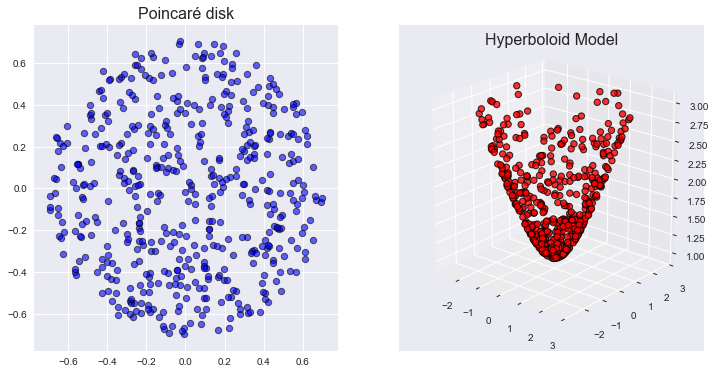

In [226]:
data = generate_data(500, radius=0.5)
mink_pts = poincare_pts_to_mink(data)
x = data[:, 0]
y = data[:, 1]
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.set_title('Poincaré disk', size=16)
ax.scatter(x, y, s=40, c='blue', edgecolor='black', linewidth=1, alpha=0.6)
ax = fig.add_subplot(122, projection = '3d')
ax.scatter(mink_pts[:, 0], mink_pts[:, 1], mink_pts[:, 2], c='red', 
           alpha=0.8, s=40, edgecolor='black', linewidth=1)
ax.set_title('Hyperboloid Model', size=16)
ax.view_init(20, -50);
plt.show();

## Optimization and the Fréchet mean

Here we have closed form expressions for all gradient terms in the optimization, and they should be possible to implement in a relatively straight forward way. With this approach we can calculate new cluster means and update the centroids until the K-Means algorithm terminates.

$$
E(\Theta)=\frac{1}{s} \sum_{i=1}^{s} \mathrm{d}^{2}\left(\Theta, x^{(i)}\right)
$$

$$
\nabla_{\Theta}^{\mathbb{R}^{n+1}} E=\frac{2}{s} \sum_{i=1}^{s}-\mathrm{d}\left(\Theta, x^{(i)}\right) \cdot\left(\left\langle\Theta, x^{(i)}\right\rangle_{n : 1}^{2}-1\right)^{-1 / 2} \cdot x^{(i)}
$$

$$
\nabla_{p}^{\mathbb{H}^{n}} E=\nabla_{p}^{\mathbb{R}^{n : 1}} E+\left\langle p, \nabla_{p}^{\mathbb{R}^{n : 1}} E\right\rangle_{n : 1} \cdot p
$$

$$
\Theta^{\text { new }}=\operatorname{Exp}_{p}\left(-\alpha \cdot \nabla_{\Theta}^{\mathbb{H}^{n}} E\right)
$$

In [223]:
def exp_map(v):
    return np.cosh(norm(v))*p + np.sinh(norm(v)) * v/norm(v)

In [62]:
# initialize random cluster assignments
def init_assign(n_samples, n_clusters):
    assignments = np.zeros((n_samples, n_clusters))
    for i in range(n_samples):
        # initialize binary assignment vector
        j = np.random.randint(0, n_clusters)
        assignments[i][j] = 1
    return assignments

# compute mean within cluster and update centroids
def init_centroids(X, assignments):
    n_samples = assignments.shape[0]
    n_clusters = assignments.shape[1]
    dim = X.shape[1]
    new_centroids = np.empty((n_clusters, dim)) 
    for i in range(n_clusters):
        # find total observations in cluster
        n_k = np.sum(C, axis=0)[i]
        # calculate new mean
        new_centroids[i] = np.sum(X[C[:, i] == 1], axis=0) / n_k
    return new_centroids

In [6]:
class PoincareKMeans():
    
    def __init__(self,n_clusters=8,n_init=20,max_iter=300,tol=1e-8,verbose=False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose =  verbose
        self.labels_ = None
        self.cluster_centers_ = None
        
    def init_assign(self):
        assignments = np.zeros((self.n_samples, self.n_clusters))
        for i in range(self.n_samples):
            # initialize binary assignment vector
            j = np.random.randint(0, self.n_clusters)
            assignments[i][j] = 1
        self.assignments = assignments
        
    def update_centroids(self, X):
        dim = X.shape[1]
        new_centroids = np.empty((self.n_clusters, dim)) 
        for i in range(self.n_clusters):
            # find total observations in cluster
            n_k = np.sum(self.assignments, axis=0)[i]
            if n_k == 0:
                new_centroids[i] = np.zeros((1, dim))
            else:
                new_centroids[i] = np.sum(X[self.assignments[:, i] == 1], axis=0) / n_k
        self.centroids = new_centroids
    
    def fit(self, X, init=None):
        """
        Uses gradient descent to find the embedding configuration in the Poincaré disk
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        init: initial configuration of the embedding coordinates
        """
        self.fit_transform(X, init=init)
        return self

    def fit_transform(self, X, max_epochs=40, verbose=False):
        """
        Fit the embedding from X, and return the embedding coordinates
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        max_epochs: maximum number of gradient descent iterations
        verbose: optionally print training scores
        """
        
        self.n_samples = X.shape[0]
        
        # initialize random centroid assignments
        self.init_assign()
        
        # loop through the assignment and update steps
        for j in range(max_epochs):
            self.update_centroids(X)
            for i in range(self.n_samples):
                # zero out current cluster assignment
                self.assignments[i, :] = np.zeros((1, self.n_clusters))
                # find closest centroid mean
                centroid_distances = list(np.sqrt(((X[i] - self.centroids)**2).sum(axis=1)))
                cx = centroid_distances.index(np.min(centroid_distances))
                self.assignments[i][cx] = 1
            if verbose:
                print('Epoch ' + str(j) + ' complete')
                print(self.centroids)
        return self.assignments

In [4]:
from IPython.core.display import HTML

def css_styling():
    styles = open("custom_style.css", "r").read()
    return HTML(styles)
css_styling()

## References
---

[1]. Learning graph-structured data using Poincaré embeddings and Riemannian K-means algorithms. Hatem Hajri, Hadi Zaatiti, Georges Hebrail. https://arxiv.org/abs/1907.01662.<br>
[2]. Begelfor, Evgeni and Michael Werman. “The World is not always Flat or Learning Curved Manifolds.” (2005).<br>
[3]. Wilson, Benjamin R. and Matthias Leimeister. “Gradient descent in hyperbolic space.” (2018).